In [1]:
import time
start_time = time.time()

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")
len(candles)

loading NQ_1


99990

In [3]:
num_actions = 3

In [4]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

#current_position = tf.keras.layers.Input(shape = (3,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(256)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(128)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(64)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(128)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(256)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(128)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(64)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(128)(m1_at)


#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at])

d = tf.keras.layers.Dense(512)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(512)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(512)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(512)(d)
d = lrelu(d)


output = tf.keras.layers.Dense(1, activation="tanh")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)



model.summary()


# In[10]:



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 60, 98)       0           ['input_3[0][0]',                
                                                                  'lambda[0][0]']             

In [5]:
model.load_weights("model.weights.h5")

In [6]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

                last_action = 0
                if output[0] > 0.6:
                    last_action = 1
                if output[0] < -0.6:
                    last_action = -1
                    
                outputs.append(output[0])
            else:
                last_action = 0


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])[55:60]])

            if(last_action == 2 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  avg_candle_range * tpm


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  avg_candle_range * tpm

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [8]:
m = MultiTimeframeCandleManager()

slm = 3
tpm = 6

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(100000)):
    step(index)
    if( index % 100 == 0 ):
        print(equity_L[-1])

print(equity_L[-1])

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

  5%|███▎                                                                     | 4506/100000 [00:00<00:04, 21384.00it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4.25
26.25
222.04999999999927
216.04999999999927
256.4500000000007
282.5
330.75
289.25


  5%|████                                                                       | 5425/100000 [00:20<08:47, 179.25it/s]

326.5499999999993
313.5
417.5
477.84999999999854
513.5999999999985
534.0
518.75
534.1000000000022
547.6000000000022
558.6000000000022
569.1000000000022


  7%|█████                                                                       | 6590/100000 [00:40<15:52, 98.06it/s]

568.5000000000036
584.2500000000036
582.2500000000036
588.1000000000022
709.5000000000036
754.8500000000022
740.3500000000022


  7%|█████▌                                                                      | 7300/100000 [00:48<16:42, 92.49it/s]

819.4500000000007
799.2000000000007
804.4500000000007
814.9500000000007
808.2000000000007


  8%|█████▉                                                                      | 7757/100000 [00:54<17:04, 90.01it/s]

836.7000000000007
815.4500000000007
821.7000000000007


  8%|██████▏                                                                     | 8062/100000 [00:58<17:32, 87.34it/s]

750.4000000000015
789.4000000000015


  8%|██████▎                                                                     | 8270/100000 [01:01<18:11, 84.05it/s]

785.9000000000015


  8%|██████▍                                                                     | 8414/100000 [01:03<18:21, 83.12it/s]

817.2000000000007
830.2000000000007


  9%|██████▌                                                                     | 8589/100000 [01:05<18:36, 81.89it/s]

859.4500000000007


  9%|██████▌                                                                     | 8711/100000 [01:06<19:18, 78.79it/s]

837.2000000000007


  9%|██████▋                                                                     | 8815/100000 [01:08<18:40, 81.38it/s]

890.3500000000022


  9%|██████▊                                                                     | 8915/100000 [01:09<18:13, 83.32it/s]

879.2000000000044


  9%|██████▊                                                                     | 9010/100000 [01:10<18:47, 80.69it/s]

864.2000000000044


  9%|██████▉                                                                     | 9118/100000 [01:12<18:10, 83.31it/s]

890.7000000000044


  9%|██████▉                                                                     | 9208/100000 [01:13<19:07, 79.15it/s]

879.8000000000029


  9%|███████                                                                     | 9315/100000 [01:14<17:57, 84.15it/s]

904.9000000000051


  9%|███████▏                                                                    | 9414/100000 [01:15<18:04, 83.54it/s]

881.9500000000044


 10%|███████▏                                                                    | 9513/100000 [01:16<17:58, 83.87it/s]

875.4500000000044


 10%|███████▎                                                                    | 9612/100000 [01:18<18:24, 81.81it/s]

895.3500000000022


 10%|███████▍                                                                    | 9711/100000 [01:19<17:51, 84.26it/s]

844.2000000000044


 10%|███████▍                                                                    | 9810/100000 [01:20<18:47, 79.99it/s]

891.6000000000058


 10%|███████▌                                                                    | 9907/100000 [01:21<18:58, 79.14it/s]

891.6000000000058


 10%|███████▌                                                                   | 10016/100000 [01:23<17:24, 86.17it/s]

891.6000000000058


 10%|███████▌                                                                   | 10115/100000 [01:24<17:54, 83.62it/s]

891.6000000000058


 10%|███████▋                                                                   | 10214/100000 [01:25<18:22, 81.40it/s]

891.6000000000058


 10%|███████▋                                                                   | 10311/100000 [01:26<18:06, 82.52it/s]

891.6000000000058


 10%|███████▊                                                                   | 10410/100000 [01:27<17:36, 84.76it/s]

891.6000000000058


 11%|███████▉                                                                   | 10510/100000 [01:28<17:43, 84.12it/s]

890.1000000000058


 11%|███████▉                                                                   | 10607/100000 [01:30<19:03, 78.20it/s]

898.1000000000058


 11%|████████                                                                   | 10706/100000 [01:31<19:18, 77.10it/s]

897.7500000000036


 11%|████████                                                                   | 10814/100000 [01:32<17:11, 86.43it/s]

824.0000000000036


 11%|████████▏                                                                  | 10914/100000 [01:34<18:12, 81.55it/s]

805.3500000000022


 11%|████████▎                                                                  | 11012/100000 [01:35<18:17, 81.08it/s]

799.3500000000022


 11%|████████▎                                                                  | 11112/100000 [01:36<17:20, 85.46it/s]

762.9000000000015


 11%|████████▍                                                                  | 11211/100000 [01:37<18:42, 79.10it/s]

802.5500000000029


 11%|████████▍                                                                  | 11314/100000 [01:38<17:53, 82.62it/s]

802.5500000000029


 11%|████████▌                                                                  | 11414/100000 [01:40<17:59, 82.07it/s]

802.5500000000029


 12%|████████▋                                                                  | 11511/100000 [01:41<18:17, 80.61it/s]

802.5500000000029


 12%|████████▋                                                                  | 11614/100000 [01:42<18:35, 79.26it/s]

802.5500000000029


 12%|████████▊                                                                  | 11713/100000 [01:44<18:22, 80.05it/s]

802.5500000000029


 12%|████████▊                                                                  | 11809/100000 [01:45<19:45, 74.41it/s]

802.5500000000029


 12%|████████▉                                                                  | 11912/100000 [01:46<18:39, 78.68it/s]

802.5500000000029


 12%|█████████                                                                  | 12016/100000 [01:47<18:39, 78.57it/s]

802.5500000000029


 12%|█████████                                                                  | 12115/100000 [01:49<17:52, 81.92it/s]

790.1500000000015


 12%|█████████▏                                                                 | 12210/100000 [01:50<20:41, 70.69it/s]

763.3499999999985


 12%|█████████▏                                                                 | 12309/100000 [01:51<19:24, 75.31it/s]

729.1499999999978


 12%|█████████▎                                                                 | 12408/100000 [01:53<21:20, 68.40it/s]

625.5499999999956


 13%|█████████▍                                                                 | 12508/100000 [01:54<18:26, 79.06it/s]

530.0499999999956


 13%|█████████▍                                                                 | 12616/100000 [01:55<18:17, 79.62it/s]

538.6999999999971


 13%|█████████▌                                                                 | 12713/100000 [01:57<17:46, 81.85it/s]

470.0


 13%|█████████▌                                                                 | 12816/100000 [01:58<17:27, 83.20it/s]

392.34999999999854


 13%|█████████▋                                                                 | 12915/100000 [01:59<17:26, 83.18it/s]

375.84999999999854


 13%|█████████▊                                                                 | 13018/100000 [02:00<17:31, 82.68it/s]

361.84999999999854


 13%|█████████▊                                                                 | 13113/100000 [02:02<19:20, 74.90it/s]

352.84999999999854


 13%|█████████▉                                                                 | 13209/100000 [02:03<18:14, 79.28it/s]

345.09999999999854


 13%|█████████▉                                                                 | 13308/100000 [02:04<17:59, 80.28it/s]

319.59999999999854


 13%|██████████                                                                 | 13408/100000 [02:05<18:08, 79.58it/s]

319.59999999999854


 14%|██████████▏                                                                | 13510/100000 [02:07<19:55, 72.33it/s]

326.6499999999978


 14%|██████████▏                                                                | 13607/100000 [02:08<17:41, 81.38it/s]

348.6499999999978


 14%|██████████▎                                                                | 13713/100000 [02:09<18:05, 79.47it/s]

347.6499999999978


 14%|██████████▎                                                                | 13813/100000 [02:11<20:07, 71.40it/s]

270.2999999999993


 14%|██████████▍                                                                | 13909/100000 [02:12<20:32, 69.85it/s]

216.14999999999782


 14%|██████████▌                                                                | 14007/100000 [02:13<17:46, 80.61it/s]

216.14999999999782


 14%|██████████▌                                                                | 14110/100000 [02:15<20:12, 70.85it/s]

216.14999999999782


 14%|██████████▋                                                                | 14212/100000 [02:16<21:34, 66.28it/s]

216.14999999999782


 14%|██████████▋                                                                | 14312/100000 [02:17<17:31, 81.47it/s]

216.14999999999782


 14%|██████████▊                                                                | 14414/100000 [02:19<17:46, 80.27it/s]

216.14999999999782


 15%|██████████▉                                                                | 14511/100000 [02:20<18:26, 77.29it/s]

216.14999999999782


 15%|██████████▉                                                                | 14615/100000 [02:21<17:38, 80.64it/s]

216.14999999999782


 15%|██████████▊                                                               | 14639/100000 [02:21<13:47, 103.12it/s]

KeyboardInterrupt



0 216.14999999999782


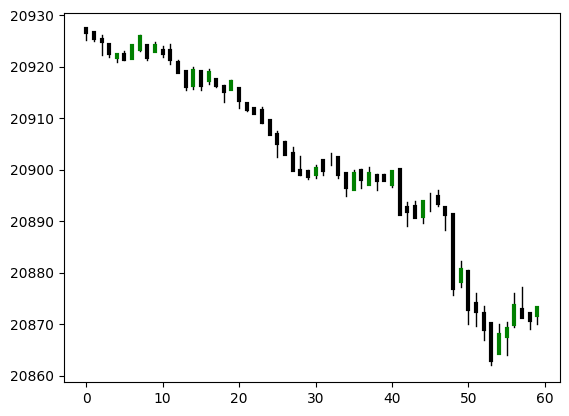

In [9]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

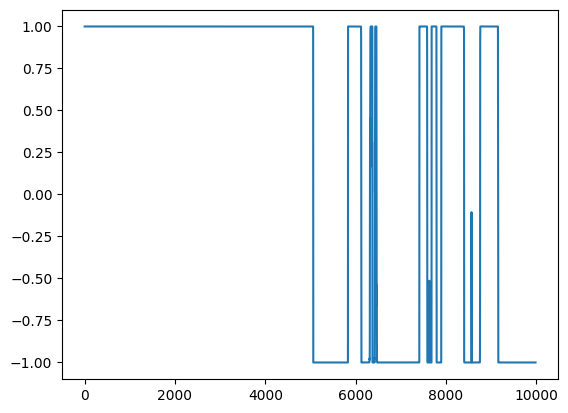

In [10]:
plt.plot(outputs)

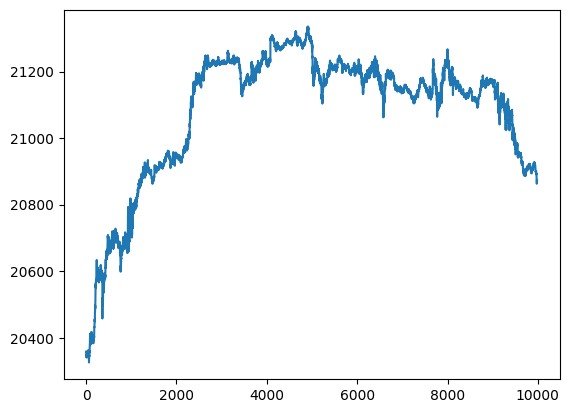

In [11]:
plt.plot([x.c for x in all_candles])

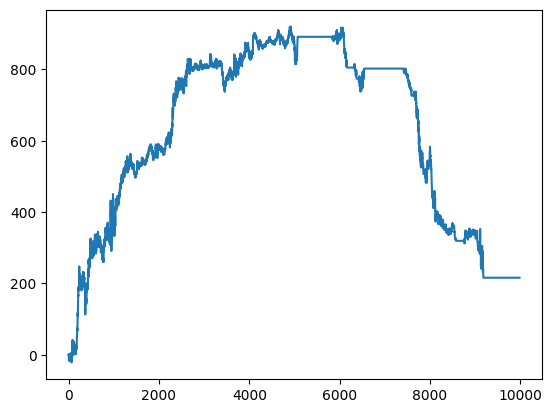

In [12]:
plt.plot(equity_L)

In [13]:
exit()